In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/2024dl/submission.csv
/kaggle/input/2024dl/train.csv
/kaggle/input/2024dl/test.csv
/kaggle/input/2024dl/DICOM/A740156/00010021
/kaggle/input/2024dl/DICOM/A481686/00010030
/kaggle/input/2024dl/DICOM/A558231/00010036
/kaggle/input/2024dl/DICOM/A608573/00010019
/kaggle/input/2024dl/DICOM/A514552/00010020
/kaggle/input/2024dl/DICOM/A672570/00010023
/kaggle/input/2024dl/DICOM/A340115/00010036
/kaggle/input/2024dl/DICOM/A325875/00010019
/kaggle/input/2024dl/DICOM/A596084/00010021
/kaggle/input/2024dl/DICOM/A520919/00010031
/kaggle/input/2024dl/DICOM/A718487/00010023
/kaggle/input/2024dl/DICOM/A681216/00010023
/kaggle/input/2024dl/DICOM/A159139/00010031
/kaggle/input/2024dl/DICOM/A741758/00010017
/kaggle/input/2024dl/DICOM/A15422/00010024
/kaggle/input/2024dl/DICOM/A29870/00010019
/kaggle/input/2024dl/DICOM/X388459/00010022
/kaggle/input/2024dl/DICOM/A521149/00010022
/kaggle/input/2024dl/DICOM/A658847/00010022
/kaggle/input/2024dl/DICOM/A570701/00010019
/kaggle/input/2024dl/DICO

In [4]:
!pip install torchsummary

In [5]:
!pip install pydicom

In [6]:
import pydicom
import pandas as pd
import numpy as np
import os
import random

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, Subset, DataLoader
from torchvision.transforms import v2
import torchvision.models as models # VGG16, ResNet50
from torchsummary import summary # summary for models

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score


import warnings
warnings.filterwarnings("ignore", category = FutureWarning)

In [33]:
class config:
    
    root = "/kaggle/input/2024dl"
    batch_size = 4
    lr = 0.0003
    epochs = 500
    weight_decay = 0.1
    seed = 228
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_classes = 3
    
print('device:', config.device)


device: cuda


In [8]:
train_data = pd.read_csv(os.path.join(config.root, 'train.csv'))
test_data = pd.read_csv(os.path.join(config.root, 'test.csv'))

print(f'Number of training samples: {train_data.shape[0]}')
print(f'Number of testing samples: {test_data.shape[0]}')

Number of training samples: 161
Number of testing samples: 41


In [9]:
train_data['Stage'].value_counts().sort_index()

Stage
1    44
2    42
3    75
Name: count, dtype: int64

In [10]:
def seed_everything(seed):
    # Set Python random seed
    random.seed(seed)
    
    # Set NumPy random seed
    np.random.seed(seed)
    
    # Set PyTorch random seed for CPU and GPU
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
    # Set PyTorch deterministic operations for cudnn backend
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [11]:
def evaluator(preds, gts):
    preds = preds.cpu().numpy() if isinstance(preds, torch.Tensor) else preds
    gts = gts.cpu().numpy() if isinstance(gts, torch.Tensor) else gts
    acc = accuracy_score(preds, gts)
    f1 = f1_score(preds, gts, average = "macro")
    misclassification_rate = 1 - acc
    
    return acc, f1, misclassification_rate

In [12]:
def train_one_epoch(model, train_loader, optimizer, scheduler, criterion, device):
    model.train() 
    
    train_loss = .0
    predictions, ground_truths = [], []
    
    for images, ages, genders, labels in train_loader:
        images = images.to(device = device, dtype = torch.float)
        ages = ages.to(device = device, dtype = torch.float)
        genders = genders.to(device = device, dtype = torch.float)
        labels = labels.to(device = device, dtype = torch.long)

        optimizer.zero_grad()
        logits = model(images, ages, genders)
        
        # Pytorch 中的分類損失函數（如 CrossEntropyLoss）期望 label 為 0 開始的整數。
        labels = torch.sub(labels, 1) # labels 1, 2, 3 -> 0, 1, 2
        loss = criterion(logits, labels)
        loss.backward()

        optimizer.step()

        train_loss += loss.item()
        preds = torch.argmax(logits, dim = 1)

        predictions.append(preds)
        ground_truths.append(labels)
    
    scheduler.step()

    train_loss /= len(train_loader)

    predictions = torch.cat(predictions)
    ground_truths = torch.cat(ground_truths)
    train_acc, train_f1, train_misclass = evaluator(predictions, ground_truths)

    return train_loss, 100*train_acc, 100*train_f1, 100*train_misclass

In [13]:
def validation(model, valid_loader, criterion, device):
    model.eval()
    valid_loss = .0
    predictions, ground_truths = [], []

    with torch.no_grad():
        for images, ages, genders, labels in valid_loader:
            images = images.to(device = device, dtype = torch.float)
            ages = ages.to(device = device, dtype = torch.float)
            genders = genders.to(device = device, dtype = torch.float)
            labels = labels.to(device = device, dtype = torch.long)

            logits = model(images, ages, genders)
            labels = torch.sub(labels, 1)
            loss = criterion(logits, labels)
            valid_loss += loss.item()
            preds = torch.argmax(logits, dim = 1)
            predictions.append(preds)
            ground_truths.append(labels)

       
        valid_loss /= len(valid_loader)

        
        predictions = torch.cat(predictions)
        ground_truths = torch.cat(ground_truths)

        
        valid_acc, valid_f1, valid_misclass = evaluator(predictions, ground_truths)
        
    return valid_loss, 100*valid_acc, 100*valid_f1, 100*valid_misclass

In [14]:
class Normalization(object):
    
    def __call__(self, image): # 定義有image之後要進行的資料處理
        changed_image = (image - image.min()) / (image.max() - image.min())
        return changed_image

def build_transform(is_train):
    """
    Create a data transformation pipeline for image preprocessing in deep learning tasks.
    """
    t = []

    if is_train:
        t.append(v2.RandomRotation(degrees=10))  
        #t.append(v2.RandomHorizontalFlip(p=0.5))  # 水平翻轉
        t.append(v2.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)))  
        t.append(v2.CenterCrop(size=(50, 50)))  
        t.append(Normalization())  
        return v2.Compose(t)

    # 驗證集只做中心裁剪和正規化
    t.append(v2.CenterCrop(size=(50, 50)))
    t.append(Normalization())
    return v2.Compose(t)

In [15]:
class ParkinsonsDataset(torch.utils.data.Dataset):

    def __init__(self, df, mode=None, transforms=None):
        self.df = df
        self.mode = mode
        self.transforms = transforms

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, x):
        age = torch.tensor(self.df.iloc[x, 1])  # 年齡
        gender = torch.tensor(self.df.iloc[x, 2])  # 性別
        index = torch.tensor(self.df.iloc[x, 4])  # 起始張數

        # 影像前處理
        image = pydicom.dcmread(config.root + self.df.iloc[x, 3]).pixel_array
        image = torch.tensor(image.astype(np.float32))
        image = image[index-1:index+2, :, :]

        if self.mode == "train":
            label = torch.tensor(self.df.iloc[x, 5])  # 標籤
            if self.transforms: image = self.transforms(image)
            return image, age, gender, label

        elif self.mode == "valid":
            label = torch.tensor(self.df.iloc[x, 5])  # 標籤
            if self.transforms: image = self.transforms(image)
            return image, age, gender, label

        elif self.mode == "test":
            if self.transforms: image = self.transforms(image)
            return image, age, gender

In [16]:
class VGGplus(nn.Module):
    def __init__(self, num_classes, input_size = (3, 50, 50), features_grad = False): # 默認輸出為分到每一類的機率
        super().__init__()
        
        # 取出 vgg16 中的特徵層
        vgg16 = models.vgg16(weights = 'IMAGENET1K_V1', progress = True) # progress = True：顯示下載進度條。
        
        # nn.Identity() 是 Pytorch 中的特殊層，不會改變輸入，只是作為佔位符。這樣你以方便修改模型結構而不會影響其整體的輸出 size
        vgg16.features[30] = nn.Identity()
        
        # 將 VGG16 的輸出特徵圖壓縮 1x1，可以得到一個 512 維的特徵向量，便於與後面的 Fully Connected Layer 結合並處理輸入的不同尺寸的圖像。
        vgg16.avgpool = nn.AdaptiveAvgPool2d(1)
        
        # 移除 VGG16 預設的分類器
        vgg16.classifier = nn.Identity()
        
        # 固定/不固定特徵層的參數值: False/True
        # features_grad: 控制是否對 VGG16 的特徵提取層進行微調(參與梯度計算)
        # 因為資料量不大，因此將 param.requires_grad 設為 False，只訓練新的分類層，減少訓練時間和 overfitting 風險。
        for param in vgg16.features.parameters():
            param.requires_grad = features_grad
        self.backend = vgg16
         
        # 增加分類層
        self.classifier = nn.Sequential(
          nn.Linear(512 + 2, num_classes) # 512: vgg16 特徵層結果, 2: age & gender
        )

    def forward(self, x, age, gender):
        output = self.backend(x)
        outputs = torch.cat([output, age.view(-1, 1), gender.view(-1, 1)], dim = 1) # output size = (batch_size, 512), age size = (batch_size), age.view(-1, 1) size = (batch_size, 1), dim = 1; columns concat
        outputs = self.classifier(outputs) # outputs size = (batch_size, 3), 3: labels
        return outputs

In [17]:
model = VGGplus(num_classes = 3)
print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 222MB/s]  


VGGplus(
  (backend): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16)

In [18]:
total_params = sum(p.numel() for p in model.parameters())
print("總參數量:", total_params)


總參數量: 14716233


Initializing model...
Epoch 1/500, Train Loss: 1.5549, Train Acc: 40.62%, Train F1: 26.45% | Valid Loss: 1.3282, Valid Acc: 39.39%, Valid F1: 24.85%, Valid Misclass: 60.61% | LR: 0.000012
Epoch 2/500, Train Loss: 1.0653, Train Acc: 45.31%, Train F1: 32.14% | Valid Loss: 1.2162, Valid Acc: 36.36%, Valid F1: 32.36%, Valid Misclass: 63.64% | LR: 0.000012
Epoch 3/500, Train Loss: 0.9980, Train Acc: 48.44%, Train F1: 30.48% | Valid Loss: 1.0848, Valid Acc: 48.48%, Valid F1: 40.51%, Valid Misclass: 51.52% | LR: 0.000012
Epoch 4/500, Train Loss: 0.8944, Train Acc: 58.59%, Train F1: 51.06% | Valid Loss: 1.0157, Valid Acc: 54.55%, Valid F1: 48.89%, Valid Misclass: 45.45% | LR: 0.000012
Epoch 5/500, Train Loss: 0.8048, Train Acc: 66.41%, Train F1: 58.54% | Valid Loss: 0.9227, Valid Acc: 54.55%, Valid F1: 48.41%, Valid Misclass: 45.45% | LR: 0.000012
Epoch 6/500, Train Loss: 0.7339, Train Acc: 68.75%, Train F1: 62.39% | Valid Loss: 0.8664, Valid Acc: 63.64%, Valid F1: 61.73%, Valid Misclass: 36.3

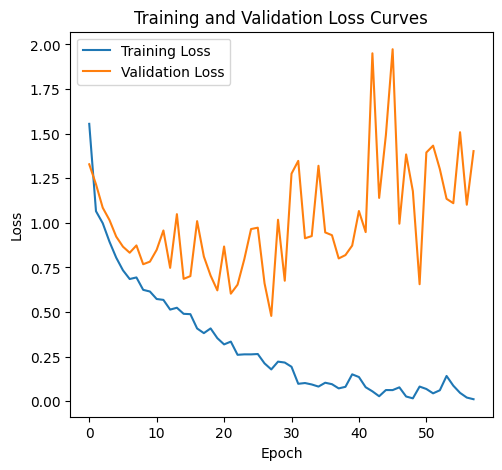

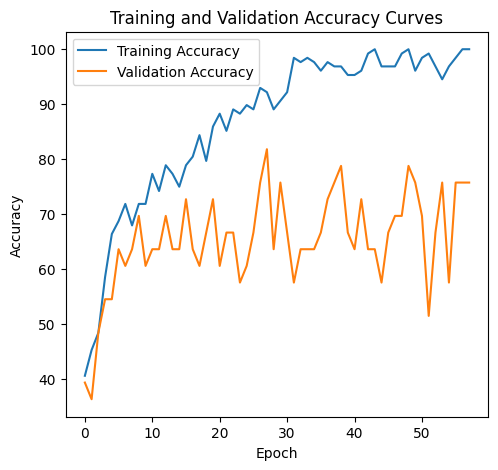

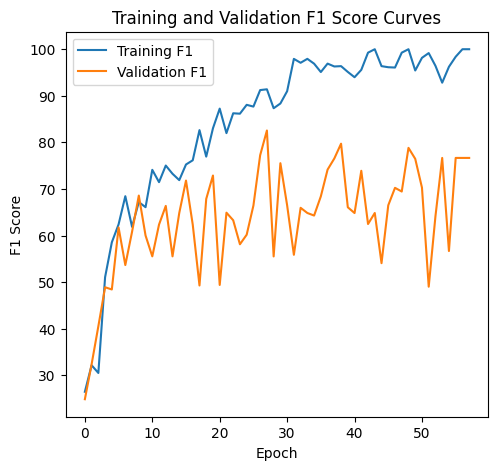

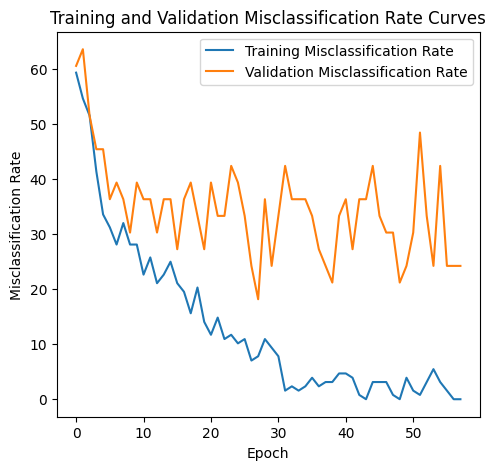

In [34]:
def main():
    seed_everything(config.seed)
    
    # Training dataframe
    train_data = pd.read_csv(os.path.join(config.root, 'train.csv'))
    
    # TODO_4: 劃分訓練數據集，通常是 8:2，但可以嘗試其他的劃分方式，例如 7:3。
    
    # Split training and validation dataset
    train_dataset, val_dataset = train_test_split(train_data, train_size = 0.8, test_size = 0.2, random_state = config.seed)

    train_dataset = ParkinsonsDataset(train_dataset, transforms = build_transform(True), mode = "train")
    val_dataset = ParkinsonsDataset(val_dataset, transforms = build_transform(False), mode = "valid")
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = config.batch_size, shuffle = True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = config.batch_size, shuffle = False)
    
    # Settings
    print("Initializing model...")
    
    model = VGGplus(num_classes=config.num_classes, features_grad=True)

    model.to(config.device)
    
    criterion = nn.CrossEntropyLoss().to(config.device)
    
    parameters = [p for p in model.parameters() if p.requires_grad] 
    
    # TODO_5: 調整合適的優化器和調度器。
    
    optimizer = torch.optim.AdamW(parameters, lr=config.lr, weight_decay=config.weight_decay)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer = optimizer,
        epochs = config.epochs,
        steps_per_epoch = train_loader.__len__(),
        max_lr = config.lr,
        anneal_strategy = 'cos'
    )

    # Early stopping settings
    patience = 30  # 當沒有改進時等待的最大輪數
    best_val_loss = float("inf")
    best_epoch = 0
    early_stop_counter = 0
    
    # Recordings
    history = {
        "train": {
            "loss": [],
            "acc": [],
            "f1": [],
            "misclass": []
        },
        "valid": {
            "loss": [],
            "acc": [],
            "f1": [],
            "misclass": []
        },
    }
    for epoch in range(config.epochs):
        train_loss, train_acc, train_f1, train_misclass = train_one_epoch(model, train_loader, optimizer, scheduler, criterion, config.device)
        valid_loss, valid_acc, valid_f1, valid_misclass = validation(model, val_loader, criterion, config.device)
        
        # 記錄損失和驗證結果
        history["train"]["loss"].append(train_loss)
        history["train"]["acc"].append(train_acc)
        history["train"]["f1"].append(train_f1)
        history["train"]["misclass"].append(train_misclass)
        history["valid"]["loss"].append(valid_loss)
        history["valid"]["acc"].append(valid_acc)
        history["valid"]["f1"].append(valid_f1)
        history["valid"]["misclass"].append(valid_misclass)

        print(f'Epoch {epoch+1}/{config.epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Train F1: {train_f1:.2f}% | Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.2f}%, Valid F1: {valid_f1:.2f}%, Valid Misclass: {valid_misclass:.2f}% | LR: {optimizer.state_dict()["param_groups"][0]["lr"]:.6f}')
        
        # Check if validation loss improved
        if valid_loss < best_val_loss:
            save_file = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "epoch": epoch,
                "args": config
            }
            best_val_loss = valid_loss
            best_epoch = epoch + 1
            torch.save(save_file, "checkpoint.pth")
            early_stop_counter = 0  # Reset counter if validation loss improves
        else:
            early_stop_counter += 1

        # Early stopping
        if early_stop_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}. No improvement in validation loss for {patience} consecutive epochs.")
            break

    best_ckpt = torch.load("checkpoint.pth", map_location = config.device, weights_only = False)
    model.load_state_dict(best_ckpt["model"])

    print(f'Best model obtained at epoch {best_epoch}, validation loss: {best_val_loss:.4f}')

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(len(history["train"]["loss"])), history["train"]["loss"], label='Training Loss')
    plt.plot(range(len(history["valid"]["loss"])), history["valid"]["loss"], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Curves')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(len(history["train"]["acc"])), history["train"]["acc"], label='Training Accuracy')
    plt.plot(range(len(history["valid"]["acc"])), history["valid"]["acc"], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy Curves')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(len(history["train"]["f1"])), history["train"]["f1"], label='Training F1')
    plt.plot(range(len(history["valid"]["f1"])), history["valid"]["f1"], label='Validation F1')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.title('Training and Validation F1 Score Curves')
    plt.show()
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(len(history["train"]["misclass"])), history["train"]["misclass"], label='Training Misclassification Rate')
    plt.plot(range(len(history["valid"]["misclass"])), history["valid"]["misclass"], label='Validation Misclassification Rate')
    plt.xlabel('Epoch')
    plt.ylabel('Misclassification Rate')
    plt.legend()
    plt.title('Training and Validation Misclassification Rate Curves')
    plt.show()
    
    # TODO_6: 畫出訓練和驗證的誤分類率圖。
   
if __name__ == "__main__":
    main()

In [35]:
def testing(model, test_loader, device):
    model.eval()  # 設置模型為推理模式，關閉 dropout 和 batch normalization
    preds = []
    
    # 禁用自動梯度計算，因為在測試過程中不需要進行反向傳播
    with torch.no_grad():  
        for image, age, gender in test_loader:
            image = image.to(device=device, dtype=torch.float)  # 將圖像移動到指定設備 (如 GPU) 並轉為浮點數
            age = age.to(device)  # 將年齡移動到指定設備
            gender = gender.to(device)  # 將性別移動到指定設備
            
            # 前向傳播，獲取模型對圖像的預測
            logits = model(image, age, gender)
            
            # 通過 `torch.argmax` 選擇預測概率最大的類別作為最終預測結果
            pred = torch.argmax(logits, dim=1)
            
            # 將這個批次的預測結果添加到 preds 列表中
            preds.append(pred)

    # 將所有批次的預測結果拼接成一個長張量
    preds = torch.cat(preds)

    # TODO_8: 因為模型輸出的 preds 為 0, 1, 2，因此我們將它們調整為 1, 2, 3。
    # 這是因為訓練集中的類別標籤範圍為 1, 2, 3，而模型輸出的類別為從 0 開始的數字。
    preds = preds + 1
    
    return preds

In [36]:
seed_everything(config.seed)

# 讀取測試數據
test_data = pd.read_csv(os.path.join(config.root, 'test.csv'))

# TODO_9: 填寫 test_dataset、test_loader、model，記得 test_loader 的 shuffle = False。

# 創建測試數據集
test_dataset = ParkinsonsDataset(test_data, transforms=build_transform(False), mode="test")

# 創建測試數據加載器
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

# 加載預訓練模型
model = VGGplus(num_classes=config.num_classes, features_grad=False)

# 將模型移動到指定設備 (CPU 或 GPU)
model.to(config.device)

# 加載保存的最佳模型檢查點
best_ckpt = torch.load(f"checkpoint.pth")

# 加載模型權重
model.load_state_dict(best_ckpt["model"])

# 使用測試數據進行推理
preds = testing(model, test_loader, config.device)

In [37]:
df = pd.read_csv(os.path.join(config.root, 'submission.csv'))
df = pd.DataFrame(df)
df['Stage'] = preds.cpu().numpy() # 將 preds 從 GPU 轉移到 CPU 並轉換為 NumPy 陣列
df.to_csv('VGGFinal.csv',index = False, header = True)